
![logo](https://www.kb.nl/sites/all/themes/kb/kblogo_en.svg)
# National Library - Koninklijke Bibliotheek


## Mining Delpher data with a Jupyter Notebook.


## Working with data from disk, using Panda's and XML parsers.

https://resolver.kb.nl/resolve?urn=DATA:kranten:kranten_pd_171x.zip

This file was downloaded and unzipped in the directory 'data'.

The structure of the Delpher downloadable set is as follows:

./README_newspapers_pd_171x.txt

./index_kranten_pd_171x.tsv

./LEESMIJ_kranten_pd_171x.txt

./README_newspapers_pd_171x.txt

./1717

./1717/02

./1717/02/02

./1717/02/02/DDD_ddd_011105161_mpeg21

./1717/02/02/DDD_ddd_011105161_mpeg21/DDD_011105161_0007_articletext.xml

./1717/02/02/DDD_ddd_011105161_mpeg21/didl.xml

./1717/02/02/DDD_ddd_011105161_mpeg21/DDD_011105161_002_alto.xml

It reflect's this general layout:

Toplevel has tsv and readme file,then per issue we've got a didl,
multiple alto's an multiple article-text's.

In [1]:
import os
import random
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import xml.etree.ElementTree as ET

from langdetect import detect
from pattern.nl import sentiment
from gensim.models import word2vec
from sklearn.decomposition import PCA

from dutch_lang import stopwords

import shutil

In [2]:
# We'll start by reading the supplied '.tsv' file using Pandas.
# https://pandas.pydata.org/

# More info on the available files see here:
# https://www.delpher.nl/data/

BASE_PATH = 'data'
tsv = BASE_PATH + os.sep

if os.path.isdir(BASE_PATH):
    # We'll use the first file which filename ends with '.tvs' in the data dir.
    tsv += [f for f in os.listdir('data') if f.endswith('tsv')][0]
else:
    # h    ttps://resolver.kb.nl/resolve?urn=DATA:kranten:kranten_pd_1855-9.zip
    print("Please download & unpack data file: https://resolver.kb.nl/resolve?urn=DATA:kranten:kranten_pd_171x.zip")

In [3]:
# Do the actual loading of the '.tsv' file, using custom colum names.
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html

df = pd.read_csv(tsv, sep='\t', names=["name","period", "zip_name", "path"])
tsv

'data/index_kranten_pd_1865-9.tsv'

## What period is covered?

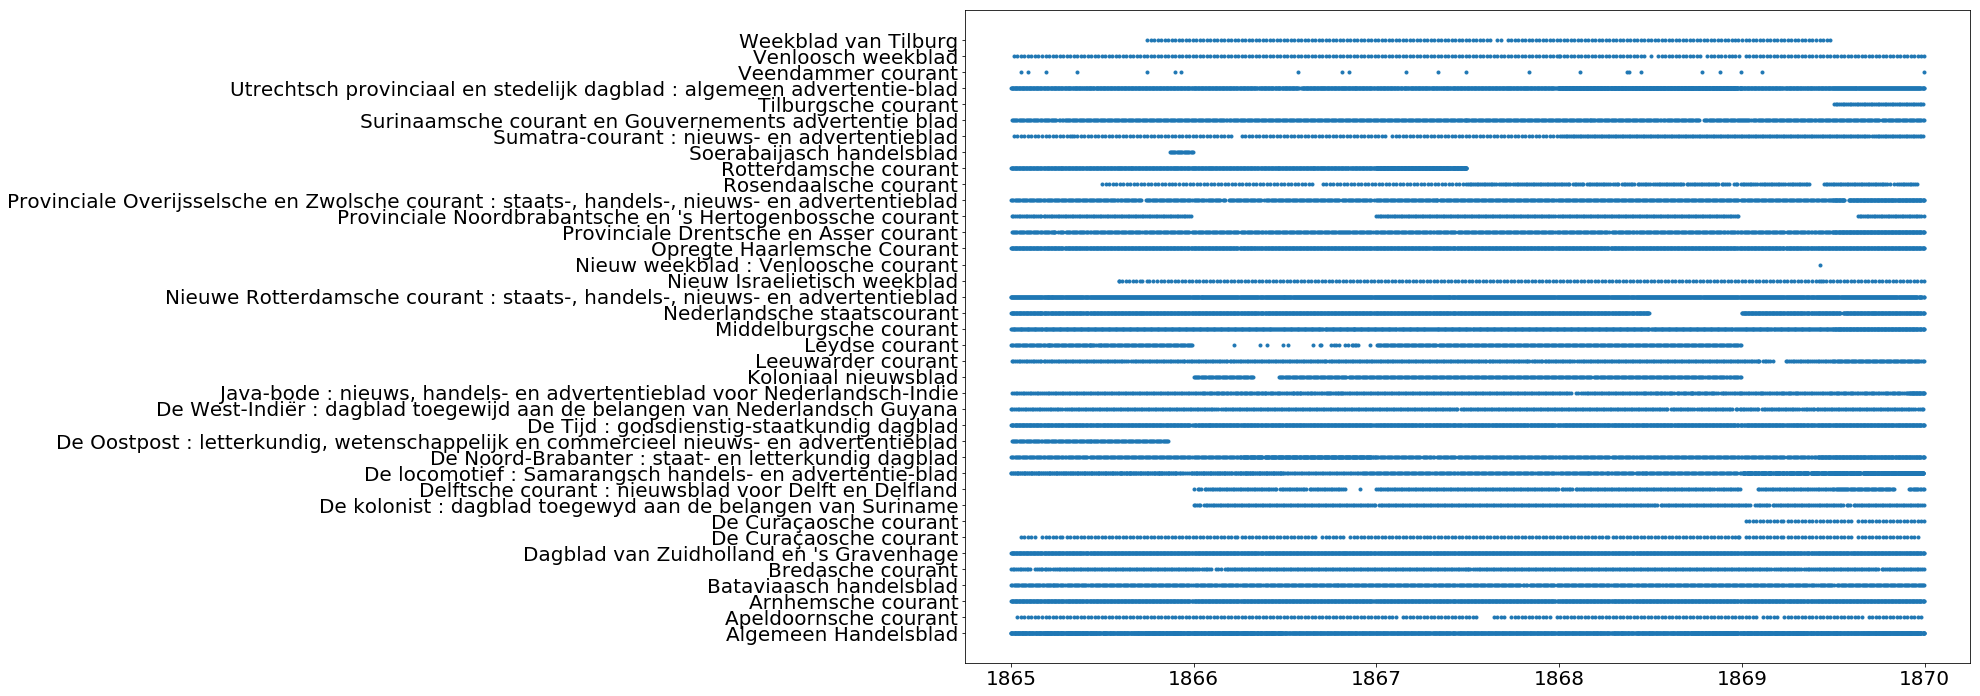

In [4]:
import matplotlib.pyplot as plt

df['period']= pd.to_datetime(df['period'], format='%Y-%m-%d')
df.set_index(df['period'],inplace=True)
plt.figure(figsize=(18, 12))
plt.rcParams.update({'font.size': 20})

plt.plot(df['period'], df['name'], '.')

## What newspaper titles are in this zip file?

In [12]:
list(df.name.unique())


['Algemeen Handelsblad',
 'Bataviaasch handelsblad',
 'Bredasche courant',
 "Dagblad van Zuidholland en 's Gravenhage",
 "De constitutioneel : nieuwe 's-Gravenhaagsche courant",
 'De Curaçaosche courant',
 'De Curaçaosche courant',
 'De grondwet',
 'Delftsche courant : nieuwsblad voor Delft en Delfland',
 'De Nederlander : nieuwe Utrechtsche courant : (staatkundig- nieuws-, handels- en advertentie-blad) / onder red. van J. van Hall',
 'De Noord-Brabanter : staat- en letterkundig dagblad',
 'De Oostpost : letterkundig, wetenschappelĳk en commercieel nieuws- en advertentieblad',
 'De Sheboygan Nieuwsbode',
 'De Tĳd : godsdienstig-staatkundig dagblad',
 'Groninger courant',
 'Java-bode : nieuws, handels- en advertentieblad voor Nederlandsch-Indie',
 'Leeuwarder courant',
 'Leydse courant',
 'Markt en aankondigingsberichten',
 'Middelburgsche courant',
 'Nederlandsche staatscourant',
 'Nieuw Amsterdamsch handels- en effectenblad',
 'Nieuwe Rotterdamsche courant : staats-, handels-, nieuws

In [23]:
# For now we'll not use the complete set,
# parts are in Dutch and some in French, 
# We'll use these selected newpaper titles:

mask = ((df['name'] == "Algemeen Handelsblad") | 
        (df['name'] == "Nieuwe Rotterdamsche courant : staats-, handels-, nieuws- en advertentieblad")
       )
wanted_paths = [BASE_PATH + os.sep + f[2:] for f in list(df[mask]["path"])]

# If you want to use all, uncomment the next line.

# wanted_paths = [BASE_PATH + os.sep + f[2:] for f in list(df["path"])]

article_strings = [] # Store all article texts in a list().

used_files = set()

for path in wanted_paths:
    # A newspaper 'issue' consists of multiple articles,
    # here we read all of it into a long list.
    #
    # You could apply a fiter for article headings and contents here,
    # Look into one of the _articletext.xml files to get an idea of
    # the structure.
        
    text_files = [path + os.sep + f for f in os.listdir(path) if f.endswith('_articletext.xml')]
    for file_name in text_files:
        used_files.add(file_name)
    
    # If you want to keep track of how many articles there are per 'issue', 
    # this is an example:
    
    # article_count.append(len(text_files))
    
    for file_name in text_files:
        # Read the XML file using lxml parser.
        tree = ET.parse(file_name)
        for item in tree.iter():
            if item.text and item.text.strip():
                
                # Here we could analyze each peace of text,
                # to see weather it is dutch or french.
                # if detect(item.text) == 'nl':
                
                # For now we'll jus add them all to list().
                article_strings.append(item.text)
                
#df.append(pd.DataFrame(article_count, lang_list, columns=['num_articles', 'lang_list']))

In [25]:
# shutil.move  src, dst
#
#
#
import shutil
for dirname in set([f for f in used_files]):
    try:
        shutil.move(dirname, "used/" + dirname)
    except:
        os.makedirs('used/' + os.path.dirname(dirname))
        shutil.move(dirname, "used/" + dirname)

## Using sentiment for splitting the text into, positive and negative

In [6]:
## Negative first

# Here we use pattern's sentiment analysis component,
# to quickly assess if an article is negative.

dirt = [a for a in article_strings if sentiment(a)[0] < -0.1]

# The list() dirt only contains articles with negative sentiment.

word_list = {}
sentences = []

for article in dirt:
    article = article.replace('. ', ' ').replace('.',' ').strip()
    
    sent = []
    
    for word in article.split(' '):
        if word.strip() and word.strip()[0].isalpha():
            if not word in word_list:
                word_list[word] = 0
            else:
                word_list[word] += 1
            if len(word) > 3 and not word.lower() in stopwords:
                sent.append(word)
    sentences.append(sent)

print([w,word_list[w] for w in word_list if word_list[w] > 11 and word_list[w] < 40 and w[0].isupper() and len(w) >3 and not w.lower() in stopwords])
neg = set([w for w in word_list if word_list[w] > 11 and word_list[w] < 40 and w[0].isupper() and len(w) >3 and not w.lower() in stopwords])

SyntaxError: invalid syntax (<ipython-input-6-d346db158e57>, line 28)

## Using word2vec to get an idea of the corpus

In [8]:
# Here we feed the negative sentences into word2vec.
#
# https://en.wikipedia.org/wiki/Word2vec
#

model = word2vec.Word2Vec(sentences, size=100, window=5, min_count=20, workers=4)

In [9]:
# In order to make a visual representation of the word2vec model,
# we'll have to reduce the number of axis in the model, often PCA is used.

# fit a 2d PCA model to the vectors
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
words = list(model.wv.vocab)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


## Word2Vec visualization words in negative sentences

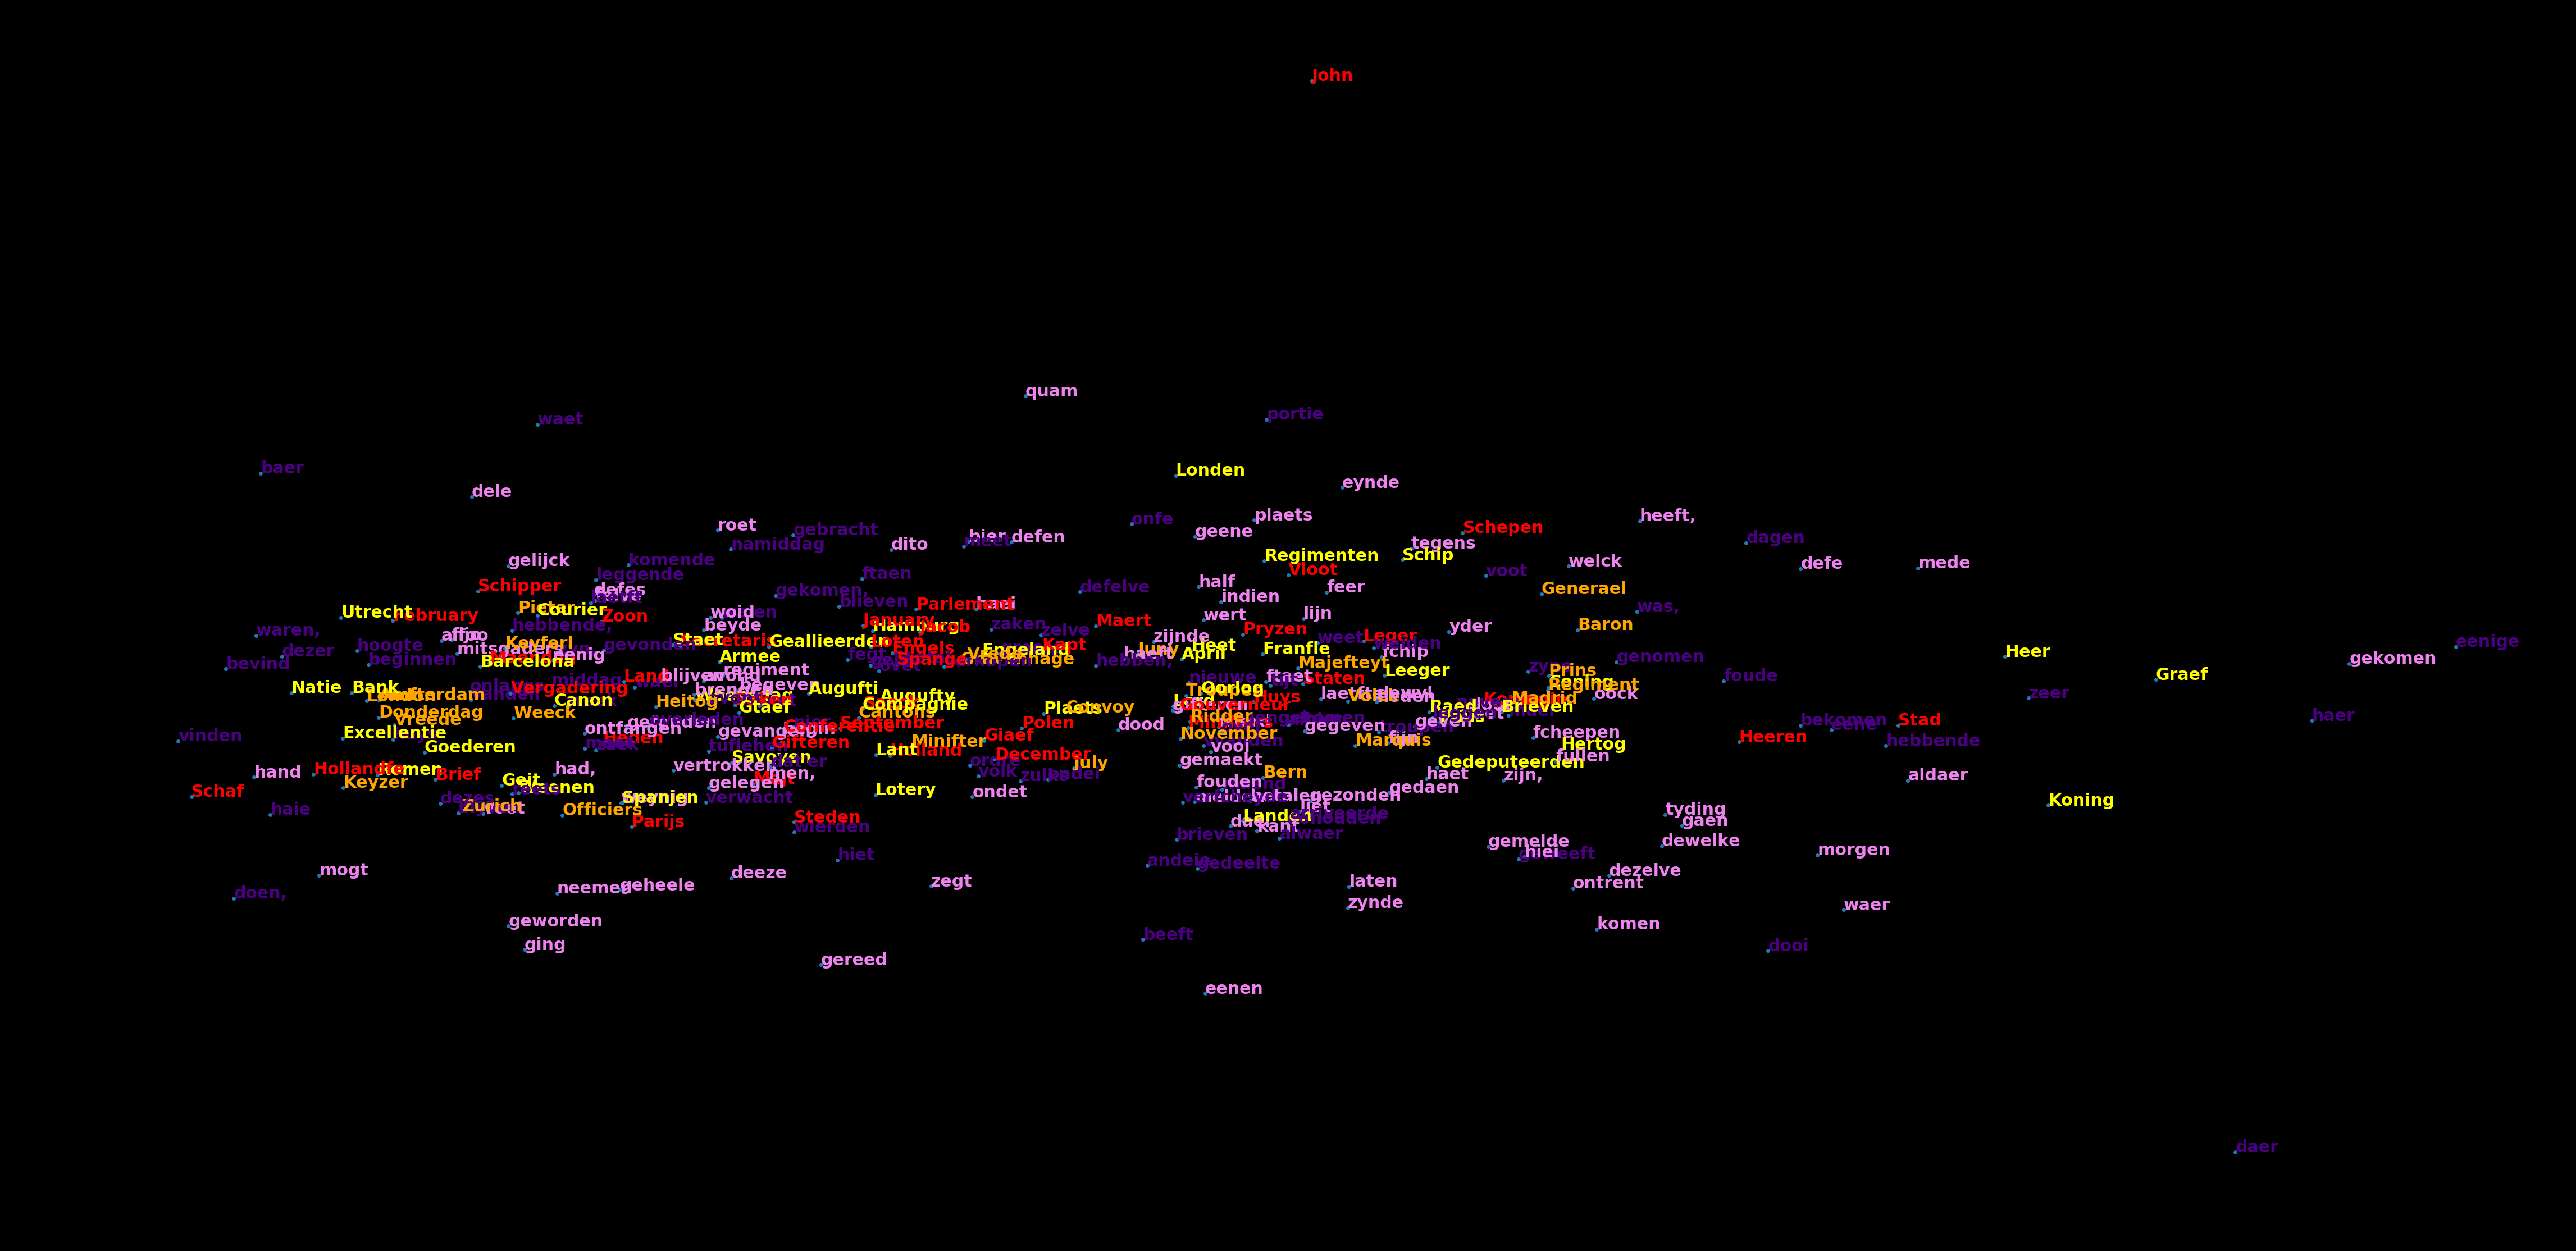

In [10]:
# Create a scatter plot of the projection
import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = 'black'
plt.figure(figsize=(80, 40), facecolor="black")
plt.rcParams["font.size"] = 30
plt.rcParams["font.weight"] = "bold"

wanted_x = []
wanted_y = []

for i, word in enumerate(words):
    if word[0].isupper():
        c = random.choice(["red", "orange", "yellow"])
        plt.annotate(word, xy=(result[i, 0], result[i, 1]), color=c)
        wanted_y.append(result[i,1])
    else:
        c = random.choice(["indigo", "violet"])
        plt.annotate(word, xy=(result[i, 0], result[i, 1]*2), color=c)
        wanted_y.append(result[i,1]*2)
    wanted_x.append(result[i,0])
    
    
plt.scatter(wanted_x, wanted_y)
plt.show()

# open the image below in new browser window for full detail.

In [11]:
## Now we will do the same for positive news.
yeaah = [a for a in article_strings if sentiment(a)[0] > 0.1]

word_list = {}
sentences = []
for article in yeaah:
    article = article.replace('. ', ' ').replace('.',' ').strip()
    
    sent = []
    
    for word in article.split(' '):
        if word.strip() and word.strip()[0].isalpha():
            if not word in word_list:
                word_list[word] = 0
            else:
                word_list[word] += 1
            if len(word) > 3 and not word.lower() in stopwords:
                sent.append(word)
    sentences.append(sent)
     
print([(w,word_list[w]) for w in word_list if word_list[w] > 500 and word_list[w] < 1000 and w[0].isupper() and len(w) >3 and not w.lower() in stopwords])
pos = set([w for w in word_list if word_list[w] > 500 and w[0].isupper() and word_list[w] < 1000 and len(w) >3 and not w.lower() in stopwords])

[('Vorft', 583), ('Willem', 929), ('Savoyen', 866), ('Geallieerden', 613), ('Major', 827), ('Congres', 548), ('Envoyé', 780), ('Saxen', 633), ('Baton', 634), ('Capt', 733), ('Madrid', 796), ('Italien', 552), ('Ridder', 606), ('BRITTANNIEN', 932), ('Lords', 872), ('Holland', 659), ('Eenige', 637), ('Ambafladeur', 881), ('Cadix', 574), ('Noorwegen', 845), ('Nederlanden', 676), ('Secretaris', 998), ('Engels', 685), ('Regeering', 744), ('Maes', 600), ('Haven', 601), ('Morgen', 721), ('Rivier', 923), ('Cornelis', 893), ('Riga', 698), ('Czaar', 820), ('Corps', 882), ('Coninckl', 745), ('Croon', 609), ('Rijck', 981), ('Saeck', 844), ('Rijcks', 577), ('Berlijn', 634), ('Paerden', 639), ('Keyferlijcke', 859), ('Luyck', 515), ('Vyanden', 793), ('Blieven', 523), ('Rebellen', 536), ('Kamer', 646), ('Leyden', 624), ('Stucken', 557), ('Hendrick', 521), ('Inleg', 547), ('Marefchal', 581), ('Officiers', 924), ('Maent', 740), ('Convoy', 782), ('Capiteyn', 738), ('Defe', 775), ('Daer', 570), ('Steden', 

In [24]:
# Here we feed the positive sentences into word2vec.
#
# https://en.wikipedia.org/wiki/Word2vec
#

model = word2vec.Word2Vec(sentences, size=100, window=5, min_count=500, workers=4)

In [25]:
X = model[model.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
words = list(model.wv.vocab)

/usr/lib/python3/dist-packages/ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """Entry point for launching an IPython kernel.


## Word2Vec visualization words in positive sentences

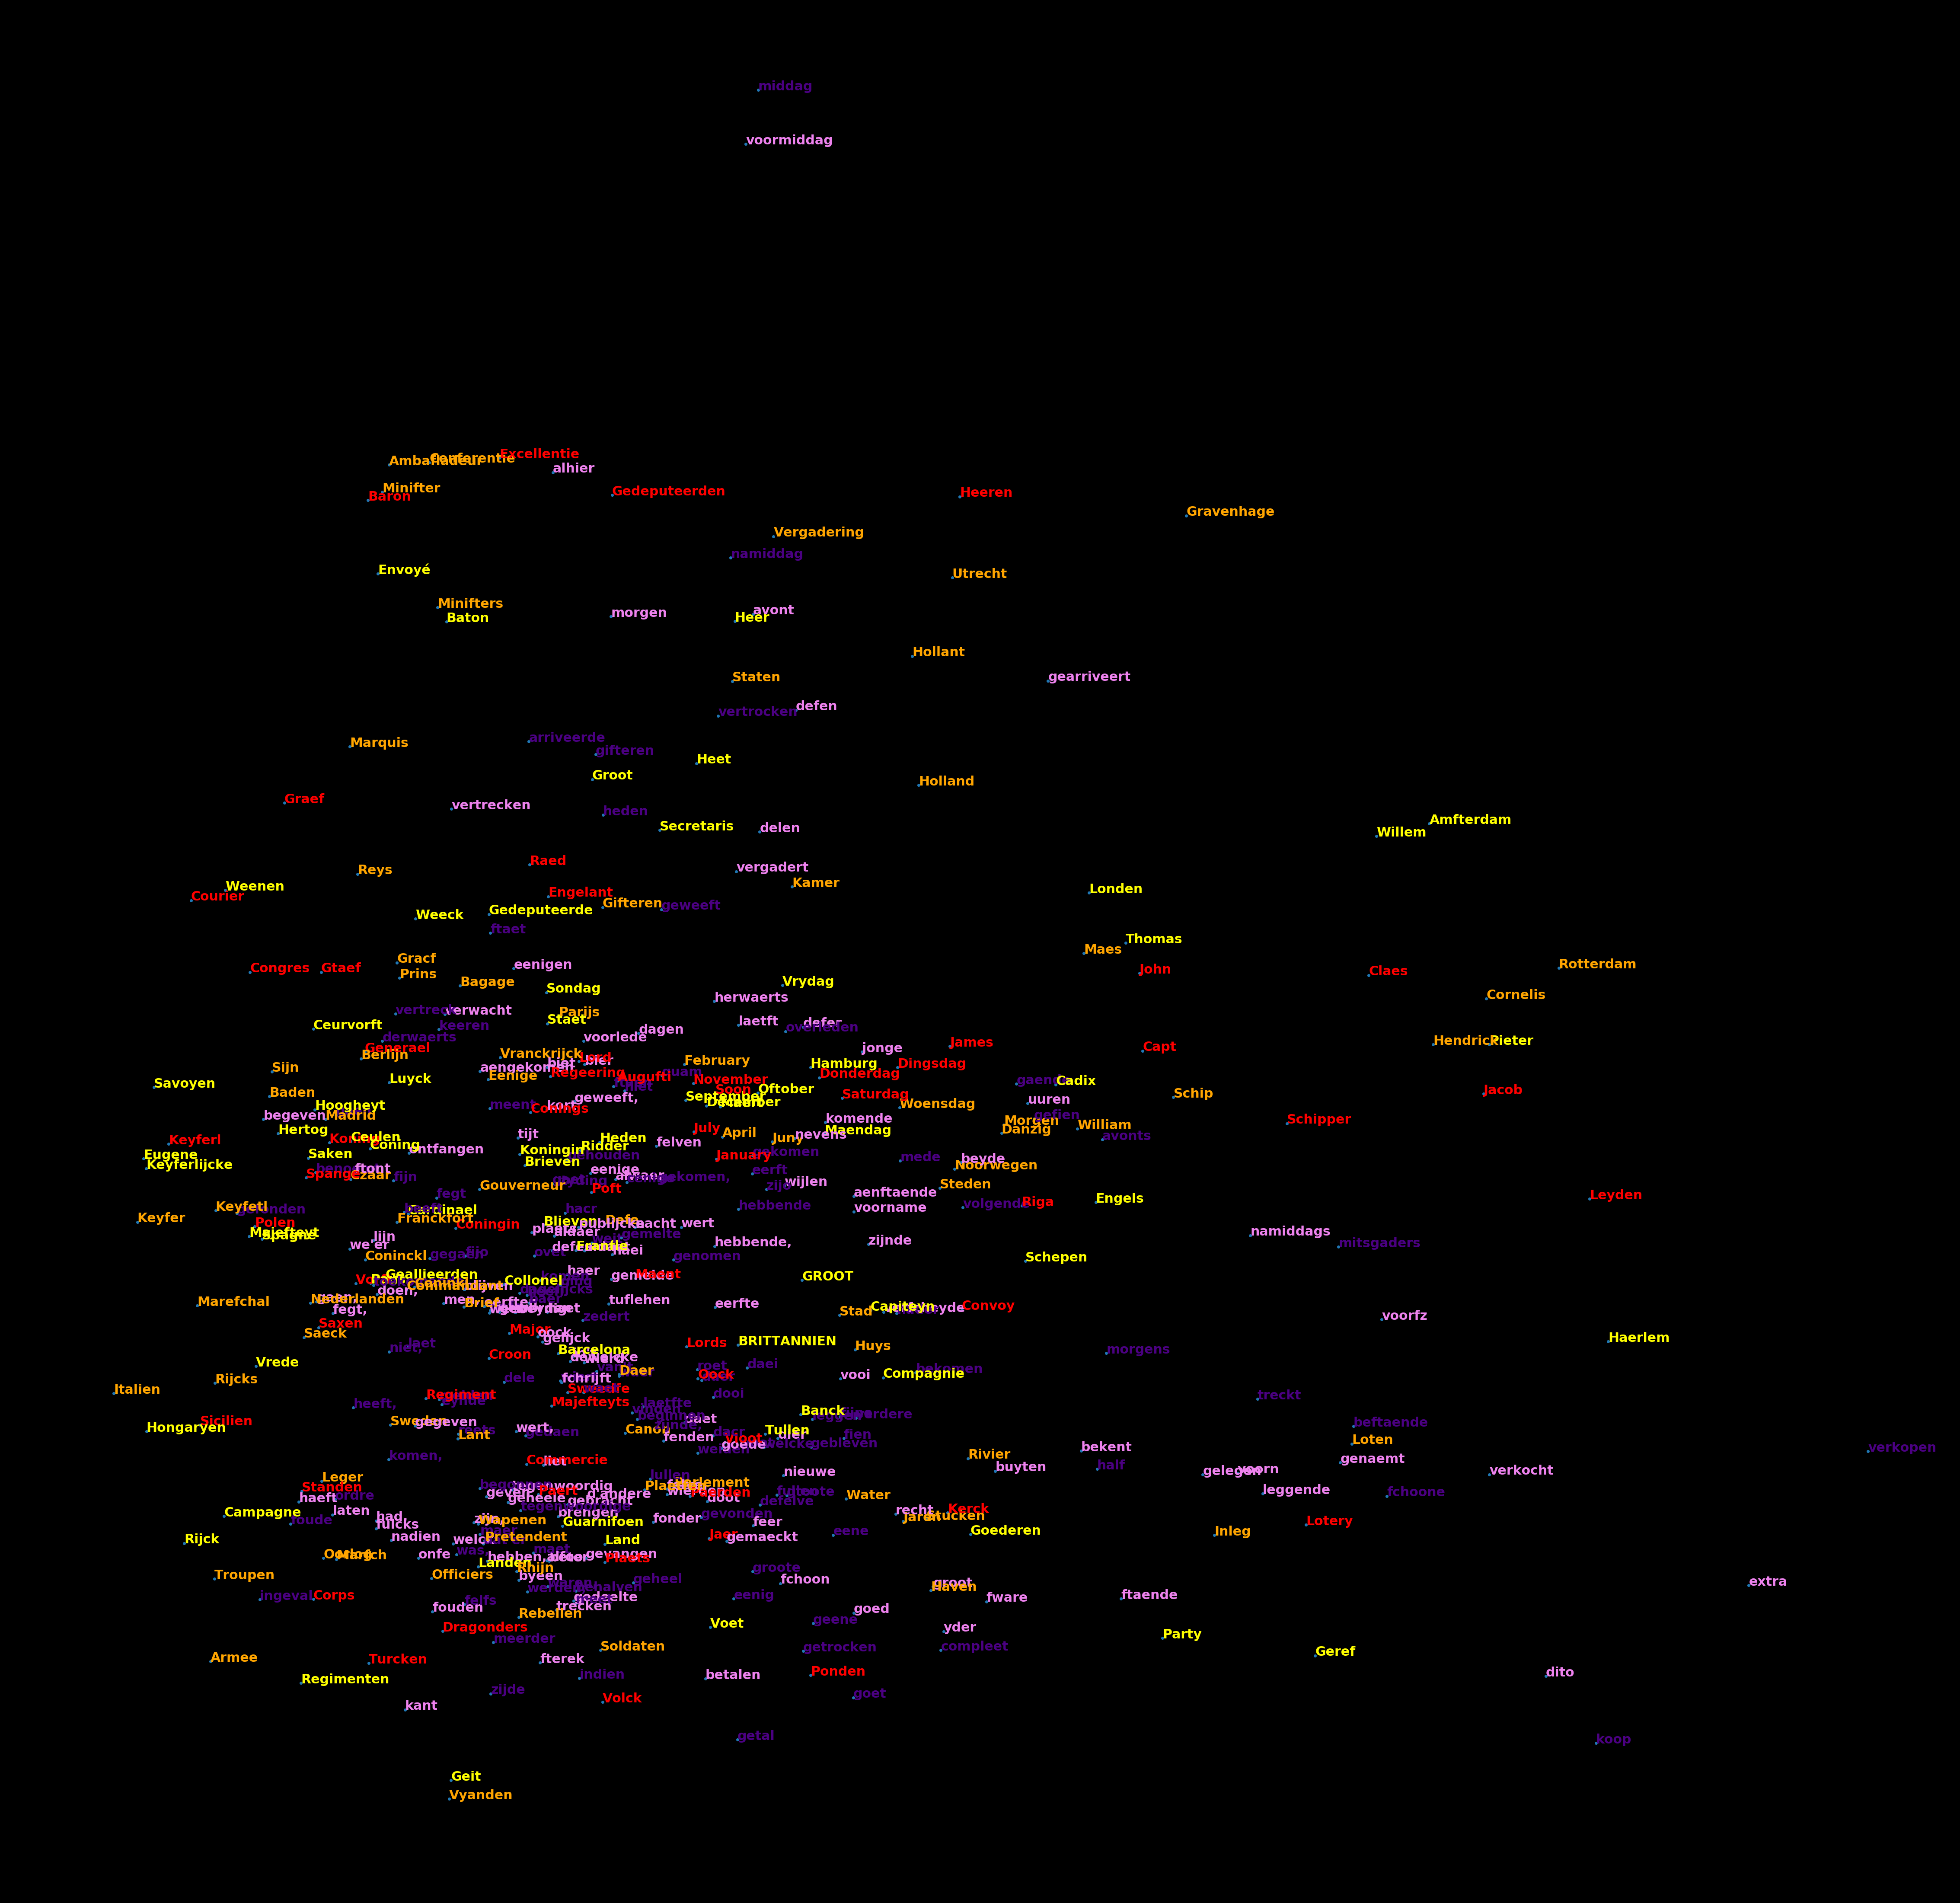

In [26]:
# Create a scatter plot of the projection
import matplotlib.pyplot as plt

plt.rcParams['axes.facecolor'] = 'black'
plt.figure(figsize=(80, 80), facecolor="black")
plt.rcParams["font.size"] = 30
plt.rcParams["font.weight"] = "bold"

wanted_x = []
wanted_y = []

for i, word in enumerate(words):
    if word[0].isupper():
        c = random.choice(["red", "orange", "yellow"])
    else:
        c = random.choice(["indigo", "violet"])
        
    plt.annotate(word, xy=(result[i, 0], result[i, 1]), color=c)
    wanted_x.append(result[i,0])
    wanted_y.append(result[i,1])
plt.scatter(wanted_x, wanted_y)
plt.show()

## Wordcloud for positive strings

In [27]:
from wordcloud import WordCloud


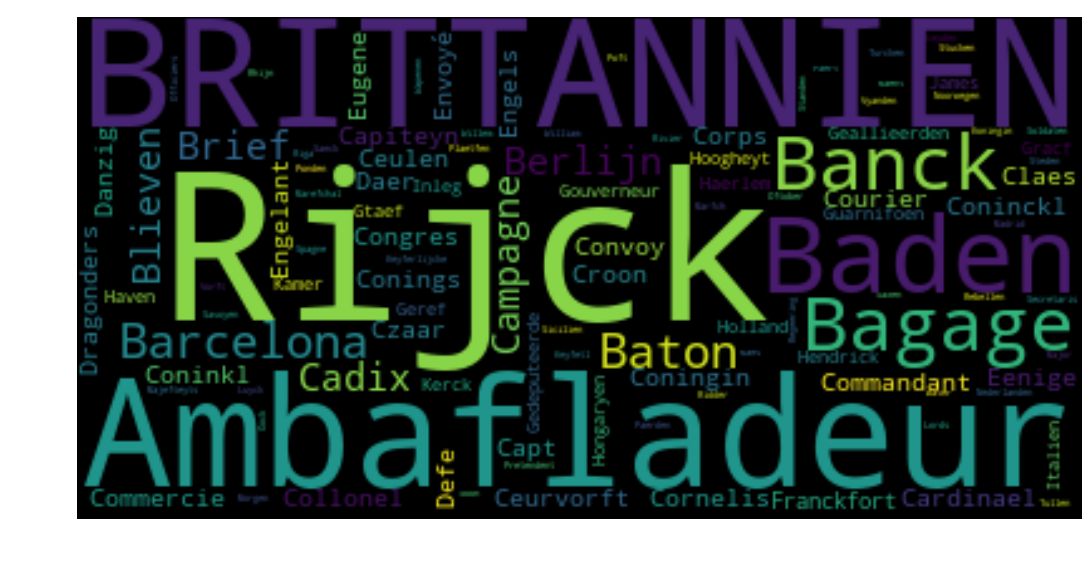

In [28]:
# Positive only
wordcloud = WordCloud().generate(str([w + " " for w in sorted(pos)]))
                                                      
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))
plt.axis("off")

plt.imshow(wordcloud, interpolation='bilinear')


## Wordcloud for negative strings

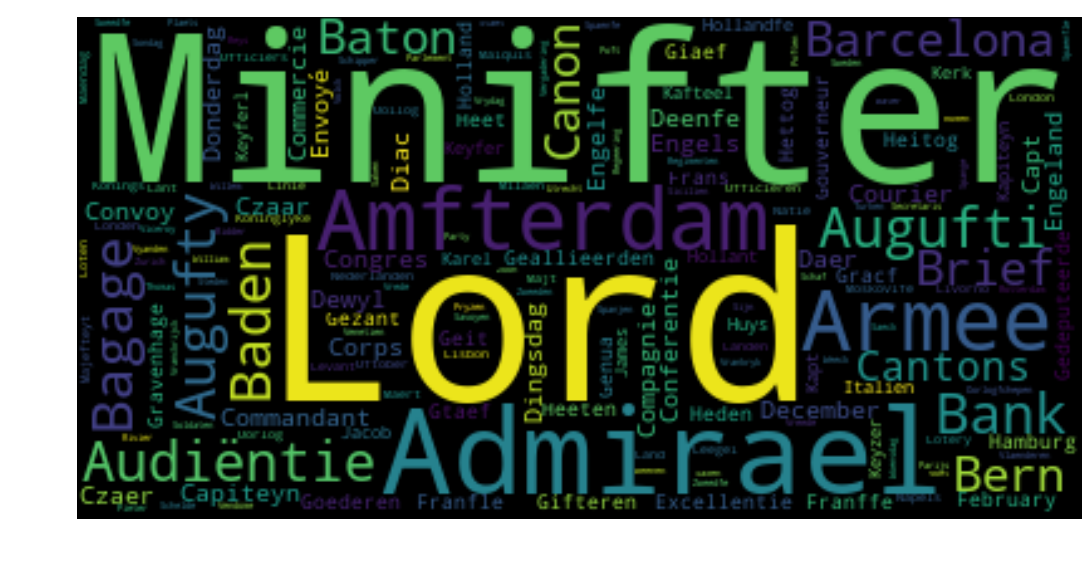

In [29]:
# Negative only
wordcloud = WordCloud().generate(str([w + " " for w in sorted(neg)]))
                                                      
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))
plt.axis("off")

plt.imshow(wordcloud, interpolation='bilinear')


## Wordcloud for negative strings - positive strings

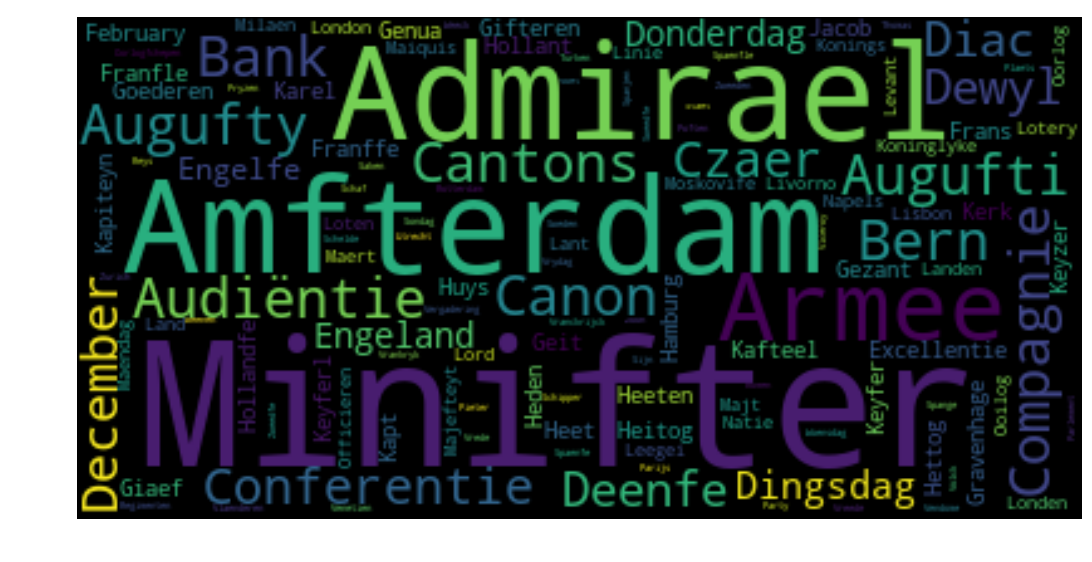

In [30]:
# Negative scored sentences - pos scored

wordcloud = WordCloud().generate(str([w + " " for w in sorted(neg-pos)]))
                                                      
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))
plt.axis("off")

plt.imshow(wordcloud, interpolation='bilinear')

## Wordcloud for positive strings - negative strings

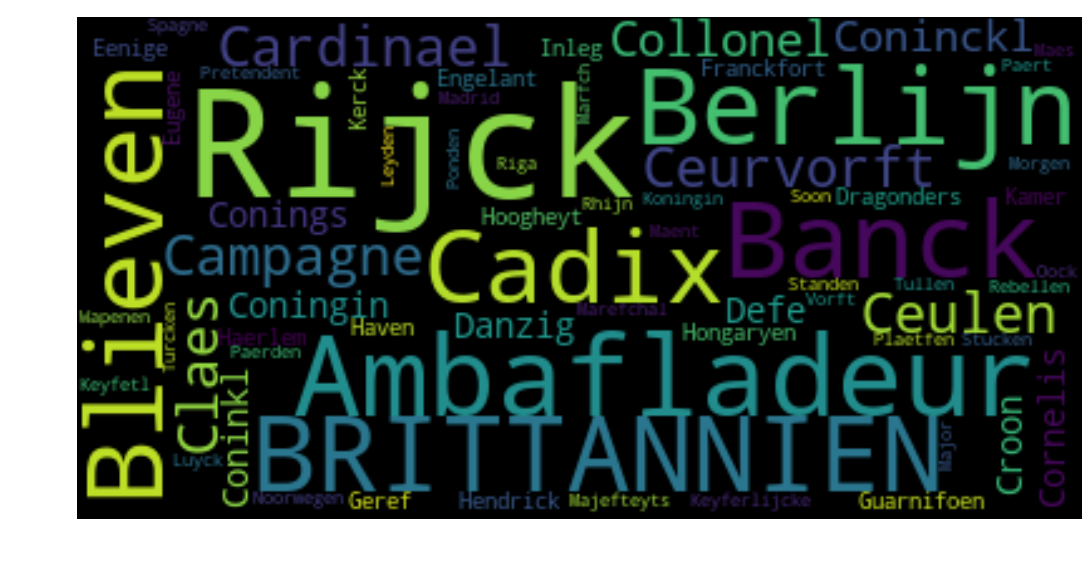

In [32]:
wordcloud = WordCloud().generate(str([w + " " for w in sorted(pos-neg)]))
                                                      
import matplotlib.pyplot as plt

plt.figure(figsize=(18, 16))
plt.axis("off")

plt.imshow(wordcloud, interpolation='bilinear')
